In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
#   LEARN FCN00
#

from __future__ import print_function
import argparse
import os, sys

import numpy as np
import pickle
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, AveragePooling2D
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray, img_dice_coeff
from fname_func import load_fnames, make_fnames

# MAXPOOLING
from create_fcn import create_fcn00

np.random.seed(2016)

Using TensorFlow backend.


In [2]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2.*intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
#
#  MAIN STARTS FROM HERE (python xxx [test_seq])
#
if __name__ == '__main__':
    
    argv = sys.argv
    argc = len(argv)
    if argc < 2:
        print('usage: %s [TEST_SEQ]'%(argv[0]))
        sys.exit(0)
    
    TEST_SEQ = argv[1]
    
    target_size = (224, 224)
    dpath_this = './'
    dname_checkpoints = 'checkpoints_UBIRIS.augumented.' + TEST_SEQ
    dname_checkpoints_fcn00 = 'checkpoints_fcn00.augumented_2'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = 'history.pkl'

    # モデルを作成
    print('creating model fcn00...')
    model_fcn00 = create_fcn00(target_size)
    
    # 学習済みの重みをロード(UBIRIS + Augumented2)
    print('loading weight..')
    epoch = 200
    fname_weights = 'model_weights_%02d.h5'%(epoch)
    fpath_weights = os.path.join(dname_checkpoints_fcn00, fname_weights)
    model_fcn00.load_weights(fpath_weights)
    print('==> done')
    
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)
        print('making directory:' + dname_checkpoints)

creating model fcn00...
loading weight..


OSError: Unable to open file (unable to open file: name = 'checkpoints_fcn00.augumented_2/model_weights_200.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [11]:
    #
    #   LEARNING MODE
    #
    # Read Learning Data
    fnames = load_fnames('data_augumented/list_train_' + TEST_SEQ + '.txt')
    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data_augumented/img','data_augumented/mask','')
    
    print('reading training data')
    X_train = load_imgs_asarray(fpaths_xs_train, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    print('reading training gt data')
    Y_train = load_imgs_asarray(fpaths_ys_train, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering) 

    # Read Validation Data
    VALIDATION = 1
    
    if VALIDATION == 1:
        fnames = load_fnames('data_augumented/list_valid_' + TEST_SEQ + '.txt')
        [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data_augumented/img','data_augumented/mask','')
    
        print('reading validation data')
        X_valid = load_imgs_asarray(fpaths_xs_valid, grayscale=False, target_size=target_size,
                                    dim_ordering=dim_ordering)
        Y_valid = load_imgs_asarray(fpaths_ys_valid, grayscale=True, target_size=target_size,
                                    dim_ordering=dim_ordering)     
    else:
        X_valid = []
        Y_valid = []

    print('==> ' + str(len(X_train)) + ' training images loaded')
    print('==> ' + str(len(Y_train)) + ' training masks loaded')
    print('==> ' + str(len(X_valid)) + ' validation images loaded')
    print('==> ' + str(len(Y_valid)) + ' validation masks loaded')

    # 前処理
    print('computing mean and standard deviation...')
    mean = np.mean(X_train, axis=(0, 2, 3))
    std = np.std(X_train, axis=(0, 2, 3))
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

reading training data
reading training gt data
==> 2232 training images loaded
==> 2232 training masks loaded
==> 0 validation images loaded
==> 0 validation masks loaded
computing mean and standard deviation...
==> mean: [91.81021 91.81021 91.81021]
==> std : [44.4275 44.4275 44.4275]


In [12]:
    print('saving mean and standard deviation to ' + fname_stats + '...')
    stats = {'mean': mean, 'std': std}
    np.savez(dname_checkpoints + '/' + fname_stats, **stats)
    print('==> done')

    print('globally normalizing data...')
    for i in range(3):
        X_train[:, i] = (X_train[:, i] - mean[i]) / std[i]
        if VALIDATION == 1:
            X_valid[:, i] = (X_valid[:, i] - mean[i]) / std[i]
    
    Y_train /= 255
    
    if VALIDATION == 1:
        Y_valid /= 255
    print('==> done')

saving mean and standard deviation to stats01.npz...
==> done
globally normalizing data...
==> done


In [13]:
    # 損失関数，最適化手法を定義
    adam = Adam(lr=1e-5)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.95, nesterov=True)
    #rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model_fcn00.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])

    # 構造・重みを保存するディレクトリーの有無を確認
    dpath_checkpoints = os.path.join(dpath_this, dname_checkpoints)
    if not os.path.isdir(dpath_checkpoints):
        os.mkdir(dpath_checkpoints)

    # 重みを保存するためのオブジェクトを用意
    fname_weights = "model_weights_{epoch:02d}.h5"
    fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
    checkpointer = ModelCheckpoint(filepath=fpath_weights, save_best_only=True)      

In [14]:
    # トレーニングを開始
    print('start training...')
    epochs = 100
    if VALIDATION == 1:
        history = model_fcn00.fit(X_train[:,:,:,:], Y_train[:,:,:,:], batch_size=32, epochs=epochs, verbose=1,
                      shuffle=True, validation_data=(X_valid, Y_valid), callbacks=[checkpointer])
    else:
        history = model_fcn00.fit(X_train[:,:,:,:], Y_train[:,:,:,:], batch_size=32, epochs=epochs, verbose=1,
                      shuffle=True, validation_data=(X_train, Y_train), validation_split=0.1, 
                    callbacks=[checkpointer])        

start training...
Train on 2232 samples, validate on 2232 samples
Epoch 1/100
2232/2232 [==============================] - 135s 60ms/step - loss: -0.5809 - dice_coef: 0.5809 - val_loss: -0.6472 - val_dice_coef: 0.6472
Epoch 2/100
2232/2232 [==============================] - 118s 53ms/step - loss: -0.6559 - dice_coef: 0.6559 - val_loss: -0.6769 - val_dice_coef: 0.6769
Epoch 3/100
2232/2232 [==============================] - 118s 53ms/step - loss: -0.6801 - dice_coef: 0.6801 - val_loss: -0.6982 - val_dice_coef: 0.6982
Epoch 4/100
2232/2232 [==============================] - 118s 53ms/step - loss: -0.6943 - dice_coef: 0.6943 - val_loss: -0.6996 - val_dice_coef: 0.6996
Epoch 5/100
2232/2232 [==============================] - 118s 53ms/step - loss: -0.7105 - dice_coef: 0.7105 - val_loss: -0.7202 - val_dice_coef: 0.7202
Epoch 6/100
2232/2232 [==============================] - 118s 53ms/step - loss: -0.7239 - dice_coef: 0.7239 - val_loss: -0.7354 - val_dice_coef: 0.7354
Epoch 7/100
2232/2232 

In [8]:
    # Save History
    f = open(dname_checkpoints + '/' + fname_history,'wb')
    pickle.dump(history.history,f)
    f.close

<function BufferedWriter.close>

checkpoints_fcn00.Gi4E/history.pkl


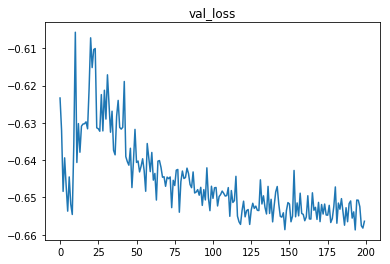

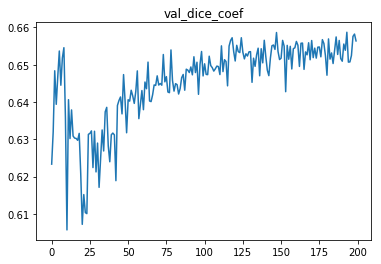

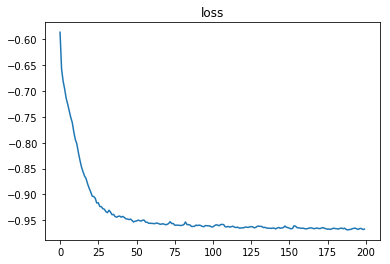

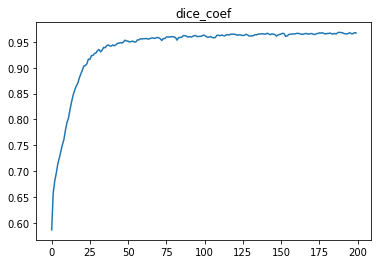

In [10]:
    #
    #   Show History
    #
    SHOW_HISTORY = 0
    
    if SHOW_HISTORY == 1:
        import matplotlib.pyplot as plt

        # load pickle
        print(dname_checkpoints + '/' + fname_history)
        history = pickle.load(open(dname_checkpoints + '/' + fname_history, 'rb'))

        for k in history.keys():
            plt.plot(history[k])
            plt.title(k)
            plt.show()